# Using composition-based features to train the e_electronic model for prediction

- Get Data from csv file

In [9]:
# import the necessary libraries
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [10]:
# some global variables
TEST_SIZE = 0.30
RANDOM_STATE = 42
N_SPLITS = 10
# The depth of the decision tree
BEST_DEPTH = None

FIG_PATH = '../figures/composition_based/unClustered/e_electronic/'

In [11]:
data = pd.read_csv('../data/composition_based_data.csv')

In [12]:
data.head()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,e_electronic,e_ionic,e_total
0,16.0,56.0,40.0,30.285714,16.326531,16.0,9.0,88.0,79.0,69.285714,...,0.0,70.0,229.0,159.0,137.000000,76.571429,70.0,9.929365,7.118969,17.048334
1,8.0,41.0,33.0,16.500000,12.250000,8.0,47.0,93.0,46.0,78.500000,...,0.0,12.0,229.0,217.0,67.000000,81.000000,12.0,4.102533,13.469477,17.572010
2,16.0,38.0,22.0,24.000000,9.142857,16.0,8.0,88.0,80.0,75.428571,...,0.0,70.0,225.0,155.0,119.571429,56.653061,70.0,6.045051,12.443616,18.488667
3,8.0,26.0,18.0,11.083333,4.125000,8.0,2.0,88.0,86.0,77.416667,...,0.0,12.0,229.0,217.0,57.833333,61.111111,12.0,3.096120,6.499905,9.596025
4,1.0,9.0,8.0,5.200000,3.400000,1.0,72.0,93.0,21.0,89.400000,...,0.0,15.0,194.0,179.0,119.600000,83.680000,15.0,1.866232,4.350314,6.216546


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Columns: 135 entries, MagpieData minimum Number to e_total
dtypes: float64(135)
memory usage: 7.5 MB


- Create X and y 

In [14]:
X = data.drop(columns=['e_total', 'e_ionic', 'e_electronic'])
y = data['e_electronic']

- Train and test set split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

- Use StandScaler to scale X_train 

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
# scale x_test
X_test_scaled = scaler.transform(X_test)

## Linear regression model

In [18]:
def model_cross_train(model, X, y):
    '''Train the model model on X and return the results of cross-validation:
        1. scores（neg_root_mean_squared_error）
        2. y_hat'''
    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
    y_hat = cross_val_predict(model, X, y, cv=kfold)
    return scores, y_hat

# After determining all the hyperparameters, train the model on the entire training set with the best hyperparameters
def model_final_train(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def model_test(model, X_test, y_test):
    '''Test the model on the test set and return the results:
        1. mean_squared_error
        2. mean_absolute_error
        3. y_pred'''
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae, y_pred

### Train the model

In [19]:
# draw parity plot
def parity_plot(mse, mae, y_test, y_pred, y_name="e_electronic", title='Parity Plot', fig_path=None, dpi=300):
    # draw parity plot
    fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
    ax.scatter(y_test, y_pred, s=2, c="#9cc3e5", marker="^")
    ax.plot(y_test, y_test, c="#aad390", zorder=-5)
    ax.set_title(title)
    # relative dielectric constant, no unit
    ax.set_xlabel("Actual " + y_name)
    ax.set_ylabel("Predicted " + y_name)
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    # make it diagonal distribution
    ax.set_aspect("equal", adjustable="box")
    # set the range of x and y to be the same
    ax.set_xlim([0, 50])
    ax.set_ylim([0, 50])
    # inward ticks
    ax.tick_params(axis='both', direction='in', length=4) 

    ax.grid(True, linestyle="--", alpha=0.4)
    
    # draw mse and mae on the plot of top_left
    # Add bbox to the plot
    bbox_props = dict(boxstyle="round,pad=0.8", ec="#aad390", lw=0.6, facecolor="white", alpha=0.6)
    ax.text(0.05, 0.95, "MSE: {:.2f}\n\nMAE: {:.2f}".format(mse, mae), transform=ax.transAxes, 
            fontsize=6, c='#9cc3e5', verticalalignment='top', bbox=bbox_props)

    plt.show()
    if fig_path:
        # Is there the directory of the fig_path
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig.savefig(fig_path+title+".png", dpi=dpi, bbox_inches='tight')

MSE: -147.65940731564004, MAE: 0


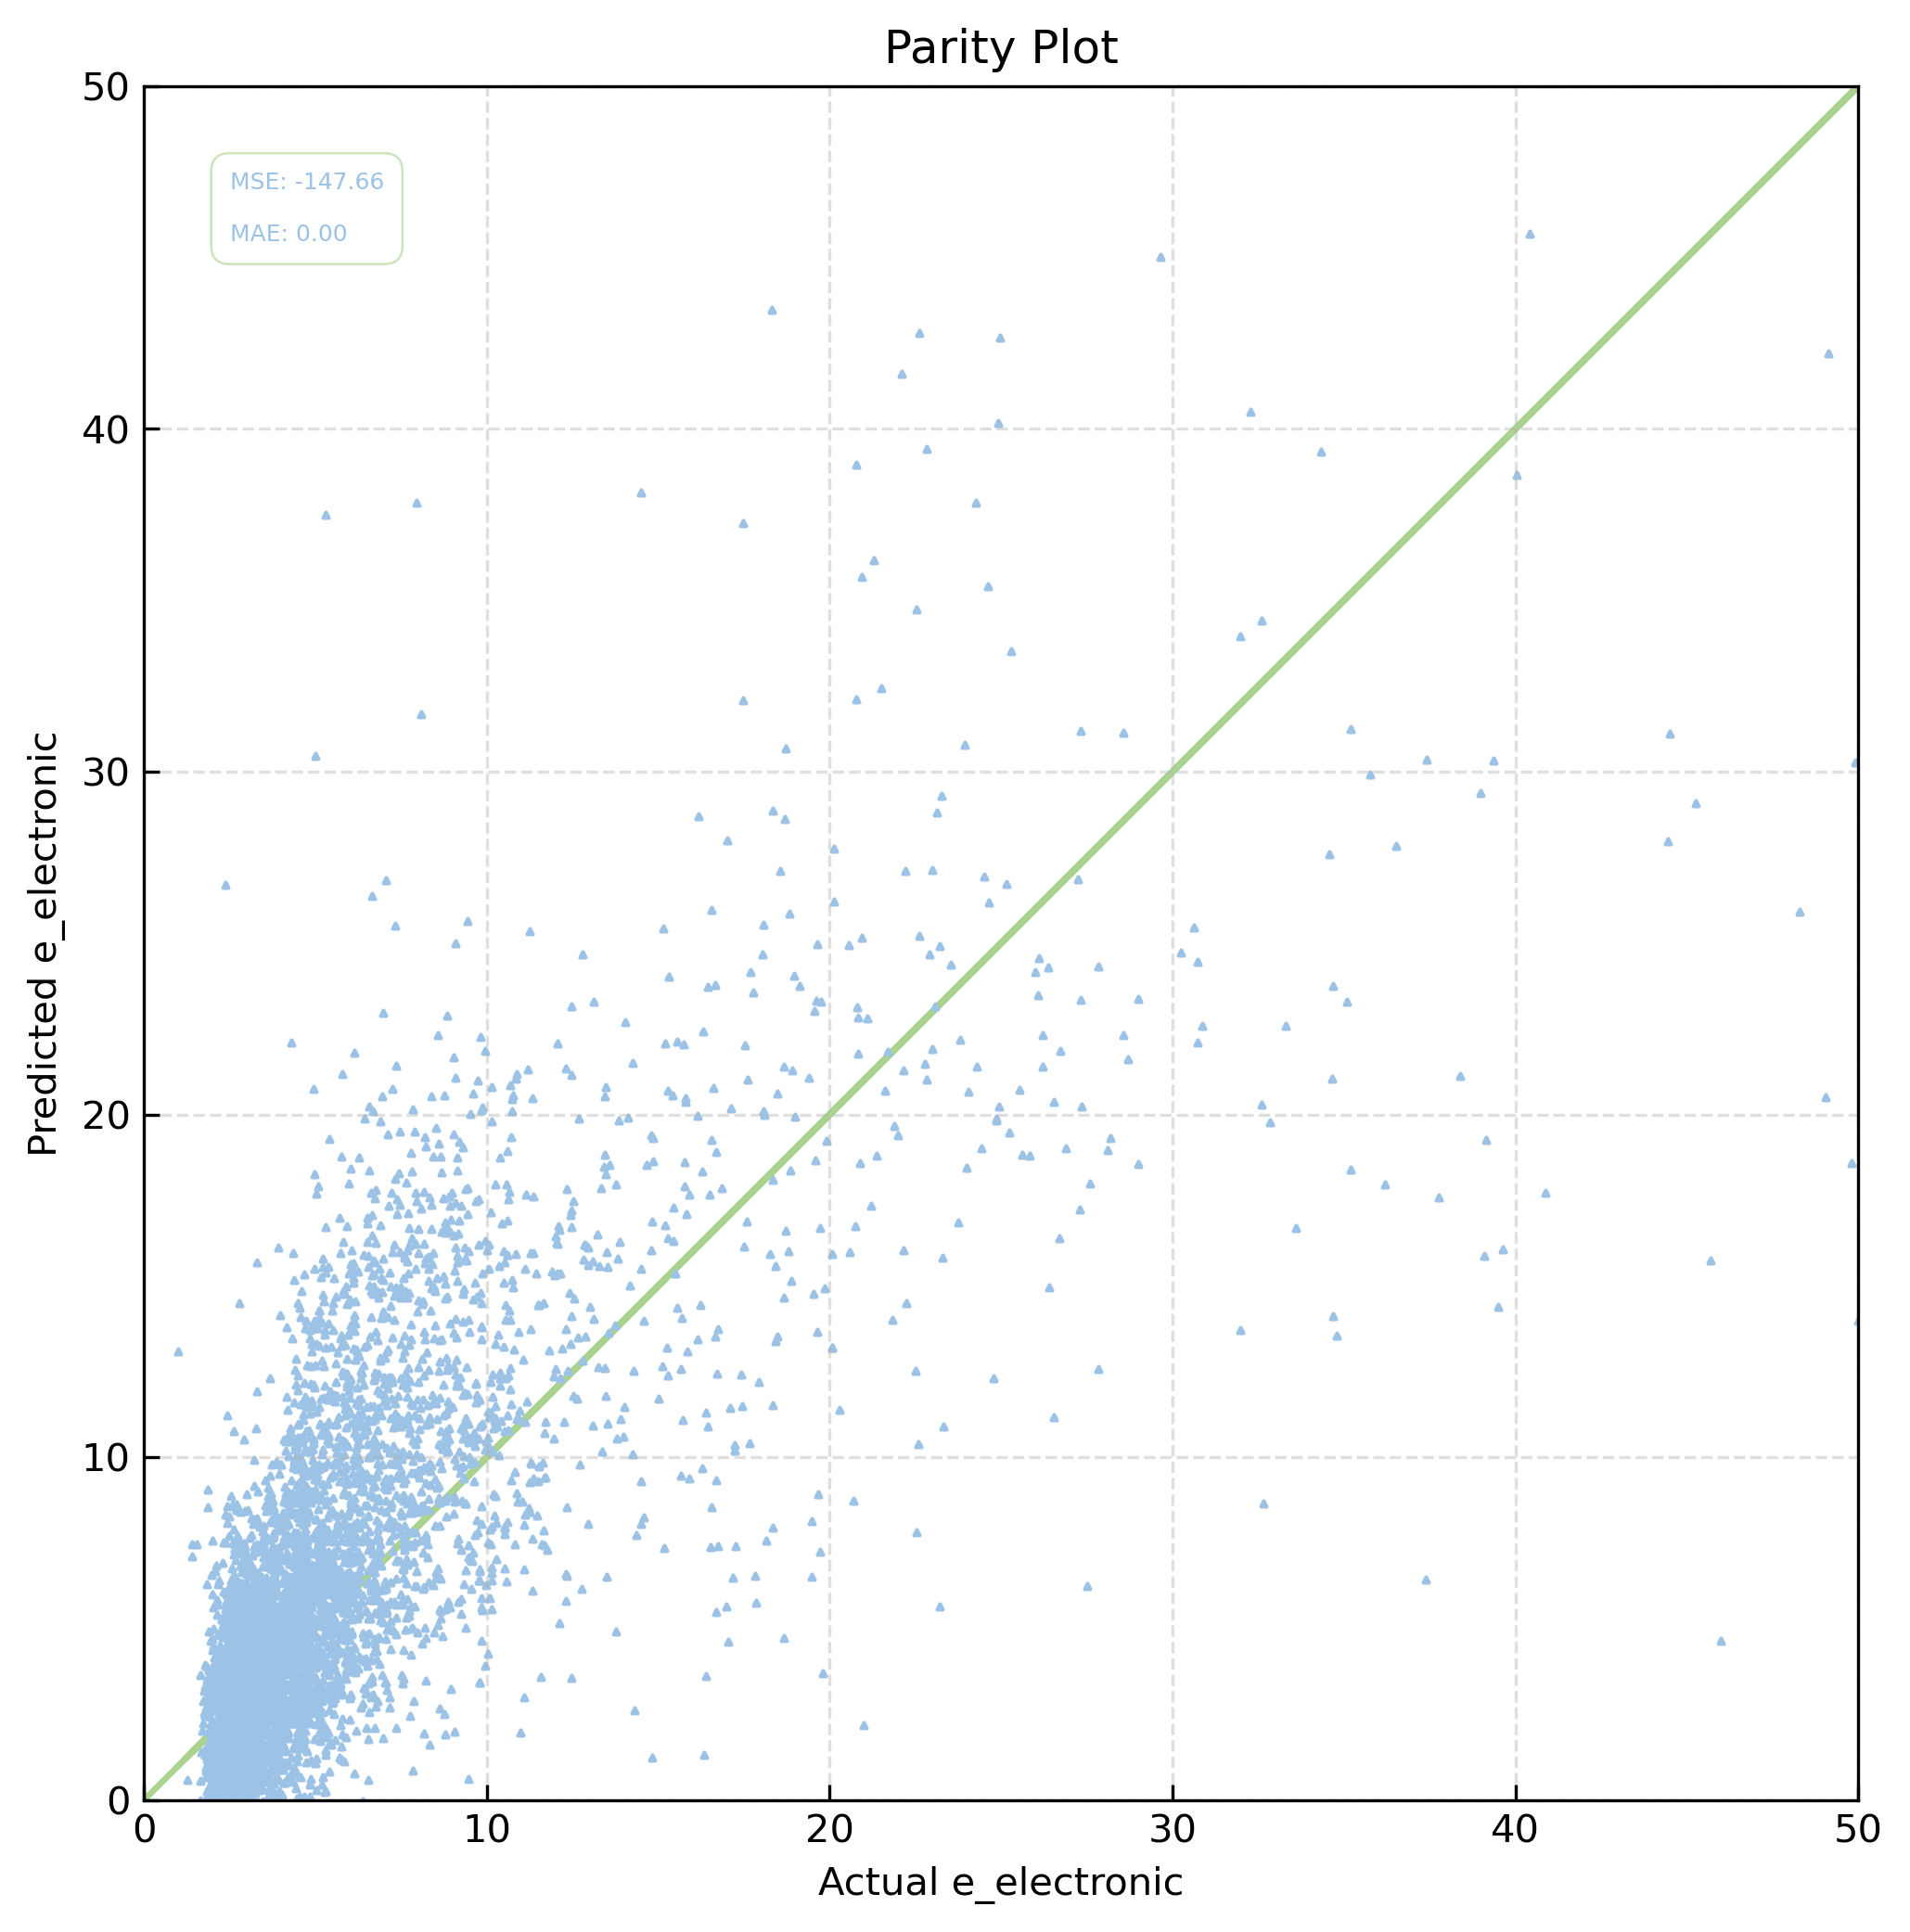

In [20]:
# This model uses the analytical solution, so it does not include the setting of the learning rate
lr = LinearRegression()
scores, y_hat = model_cross_train(lr, X_train_scaled, y_train)

def plot_scores(mse, mae, y_train, y_hat, title='Parity Plot', fig_path=None, dpi=300):
    '''...'''
    print(f'MSE: {mse}, MAE: {mae}')

    # parity plot
    parity_plot(mse, mae, y_train, y_hat, y_name='e_electronic', title=title, fig_path=fig_path, dpi=dpi)


fig = plot_scores(-scores.mean()**2, 0, y_train, y_hat)

In [21]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

### Model Test：

MSE: 133.4576174197926, MAE: 3.7713066802913855


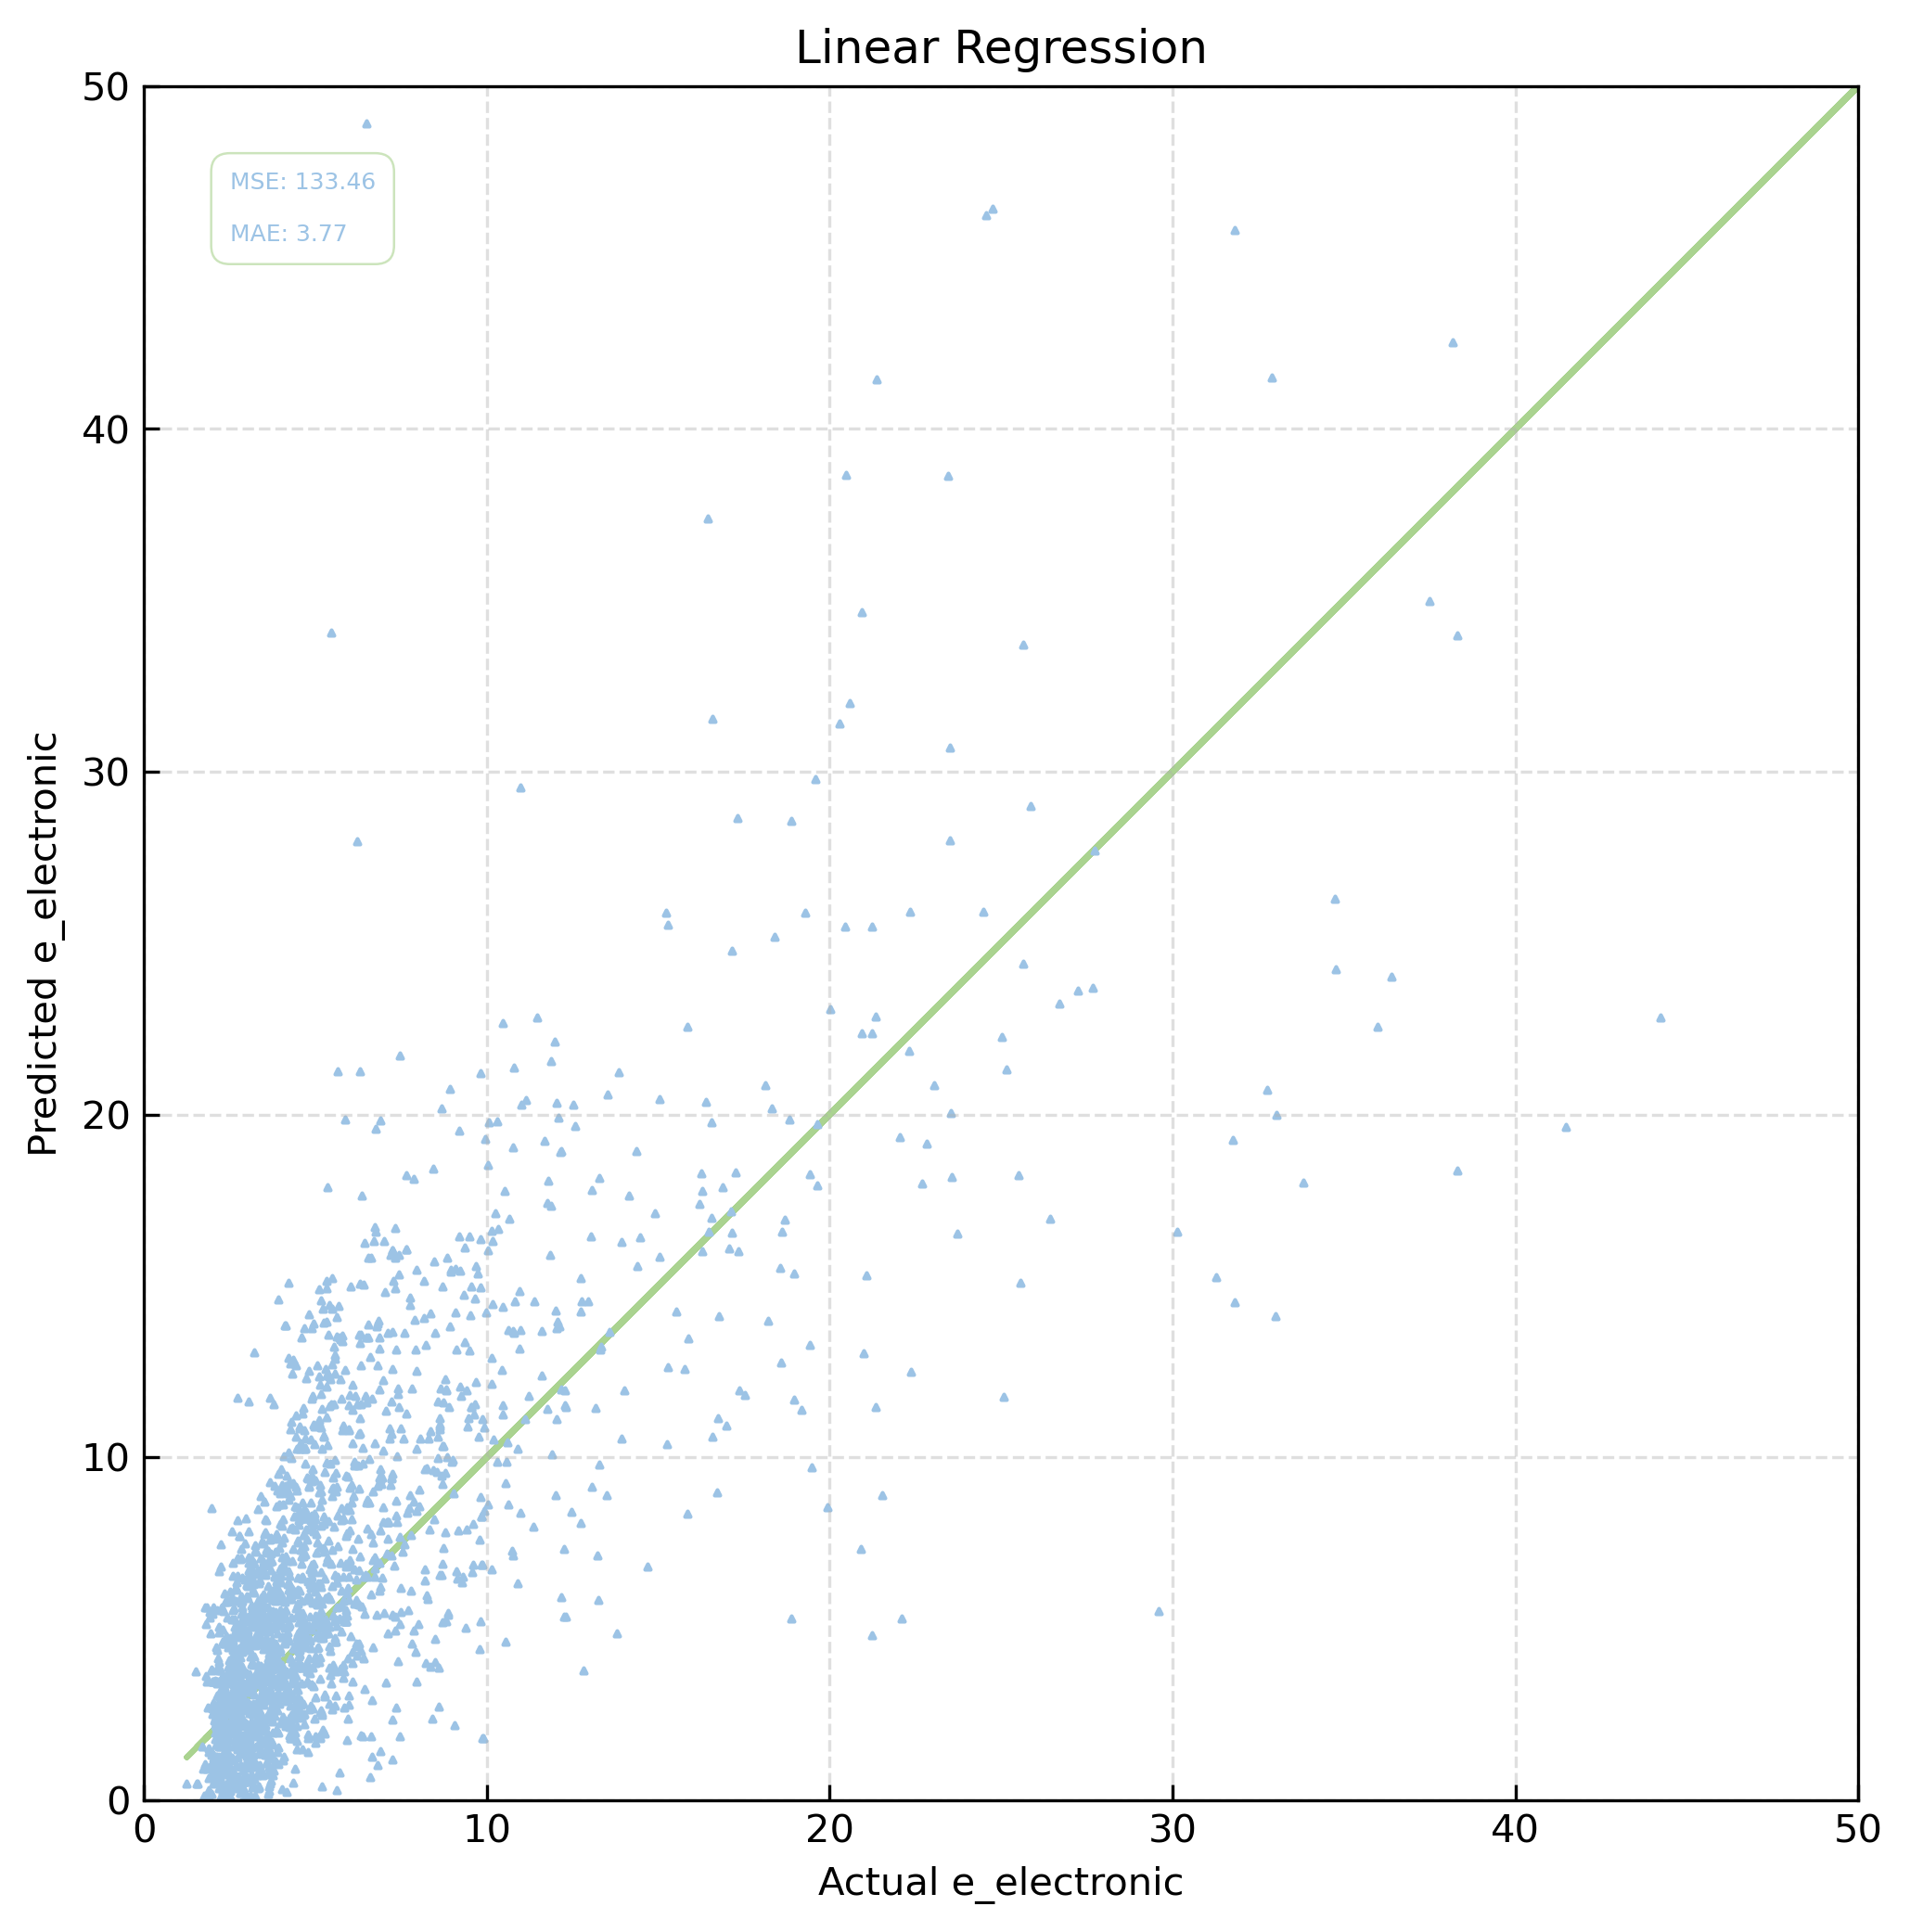

In [22]:
mse, mae, y_pred = model_test(lr, X_test_scaled, y_test)
plot_scores(mse, mae, y_test, y_pred, title='Linear Regression', fig_path=FIG_PATH)

## Decision Tree Model

-13.536161265900787 5
MSE: 183.22766181647282, MAE: 0


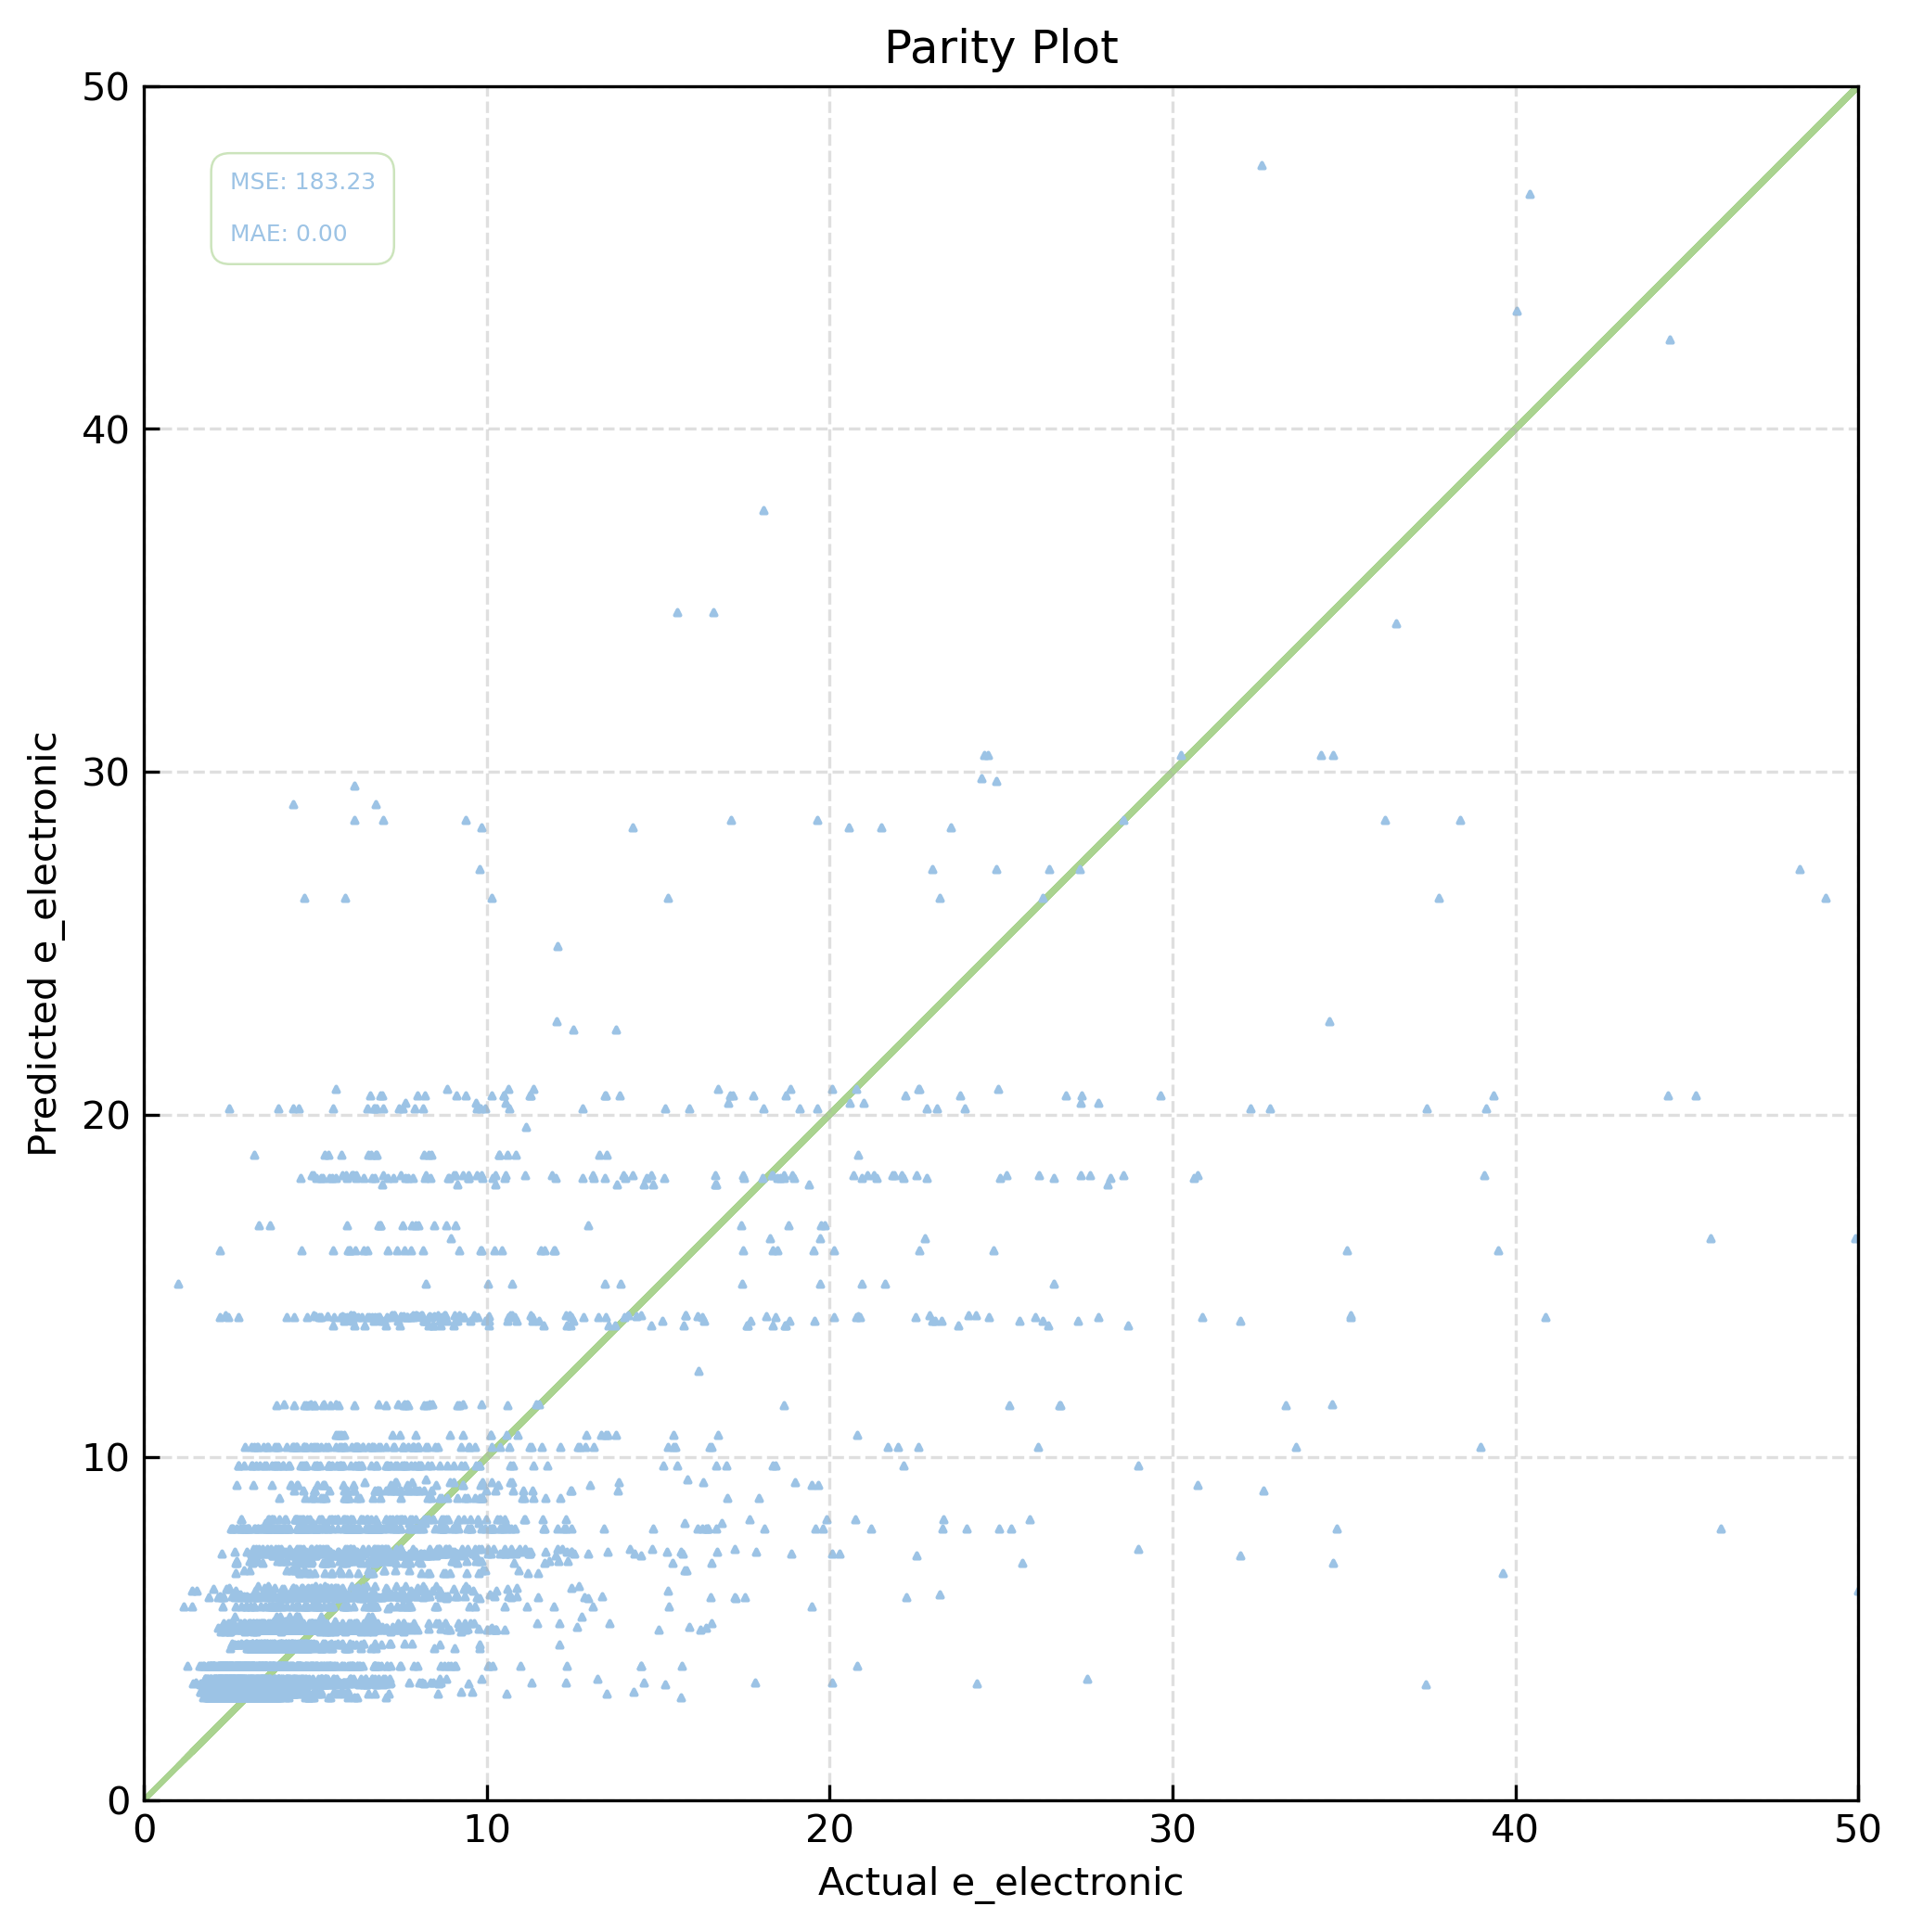

-14.130606013573598 6
-13.92185101615714 7
-14.294125911488464 8
-13.18507321723286 9
MSE: 173.8461557437913, MAE: 0


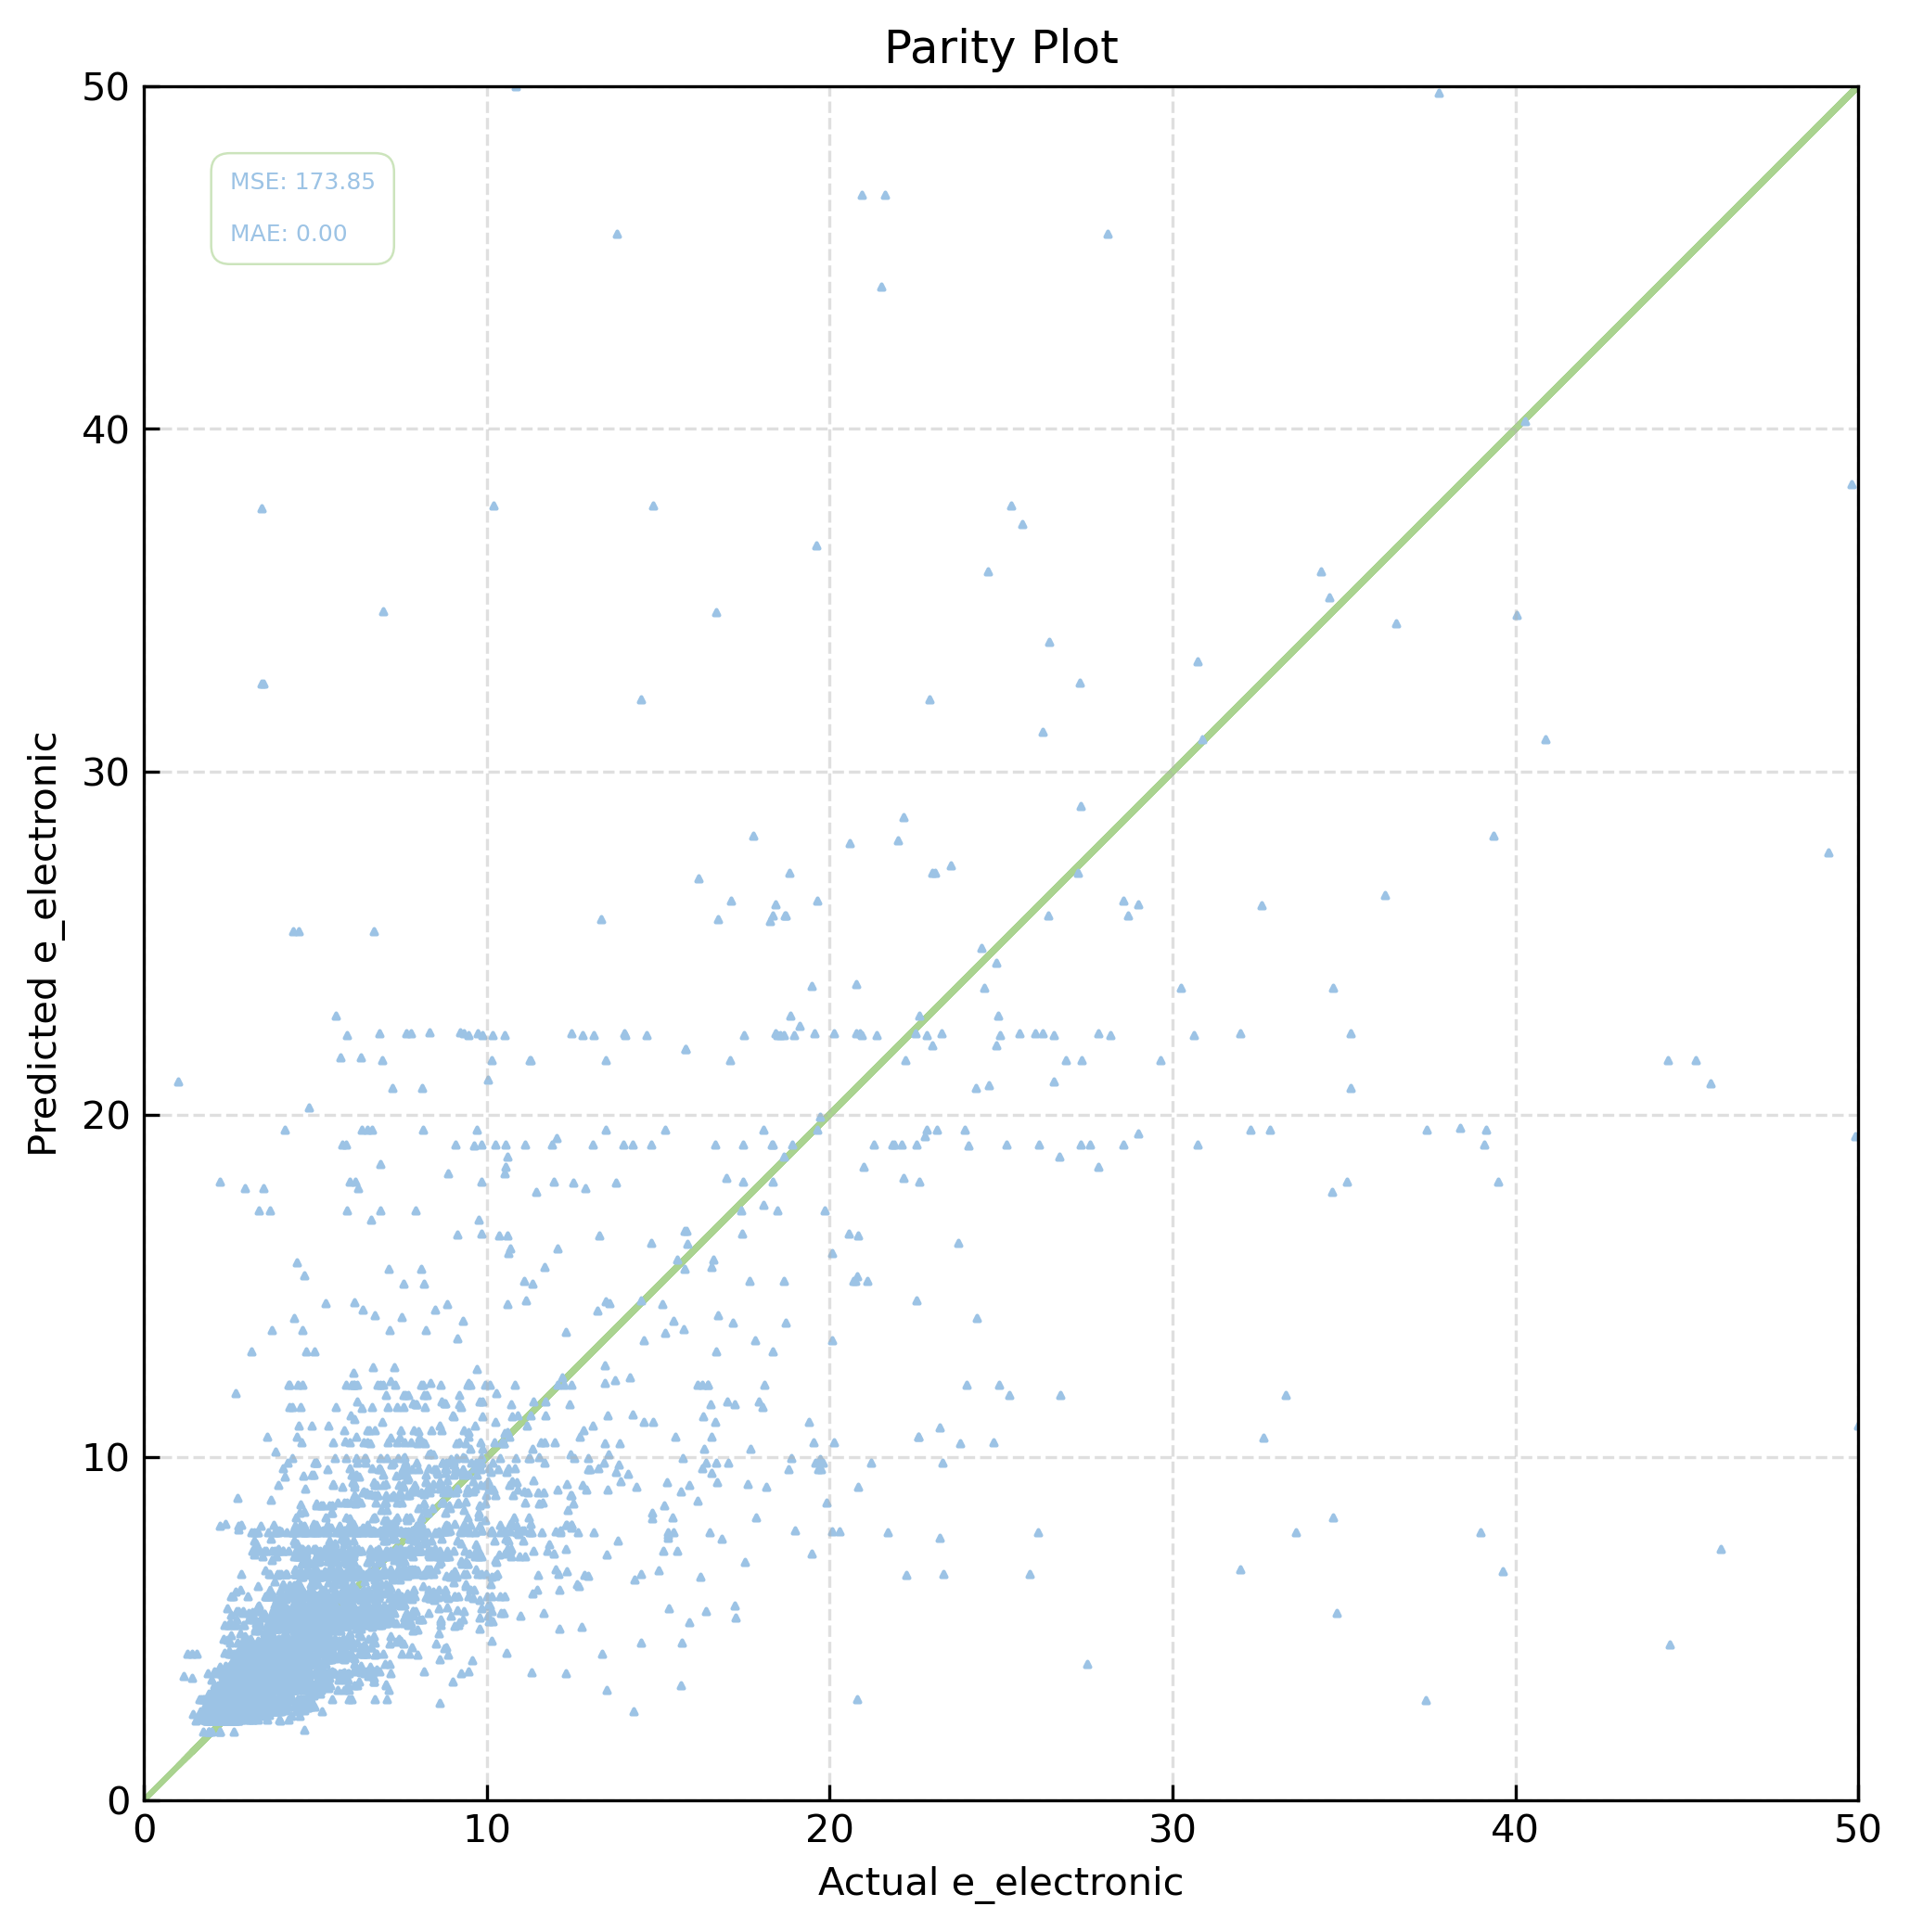

-16.236771829261 10
-16.104146903208242 11
-14.468760631663596 12
-15.28795192488405 13
-15.81105938769485 14
-16.450594172177635 15
-14.910023486740167 16
-15.774721356060237 17
-13.79793989619184 18
Best depth: 9


In [23]:
from sklearn.tree import DecisionTreeRegressor, plot_tree       # ML model

# decide the best depth of the decision tree
max_scores=-1e5
BEST_DEPTH=0
for depth in range(5, 19):
    dt = DecisionTreeRegressor(max_depth=depth,random_state=RANDOM_STATE)      # decision tree constructor
    scores, y_hat = model_cross_train(dt, X_train_scaled, y_train)     
    print(scores.mean(), depth)                         
    if scores.mean() > max_scores:
        max_scores = scores.mean()
        BEST_DEPTH = depth
        plot_scores(scores.mean()**2,0, y_train, y_hat)

print(f'Best depth: {BEST_DEPTH}')

### Model Train

In [24]:
dt = DecisionTreeRegressor(max_depth=BEST_DEPTH, random_state=RANDOM_STATE)
dt = model_final_train(dt, X_train_scaled, y_train)

### Model Test

MSE: 190.47736350238102, MAE: 2.7233743012745664


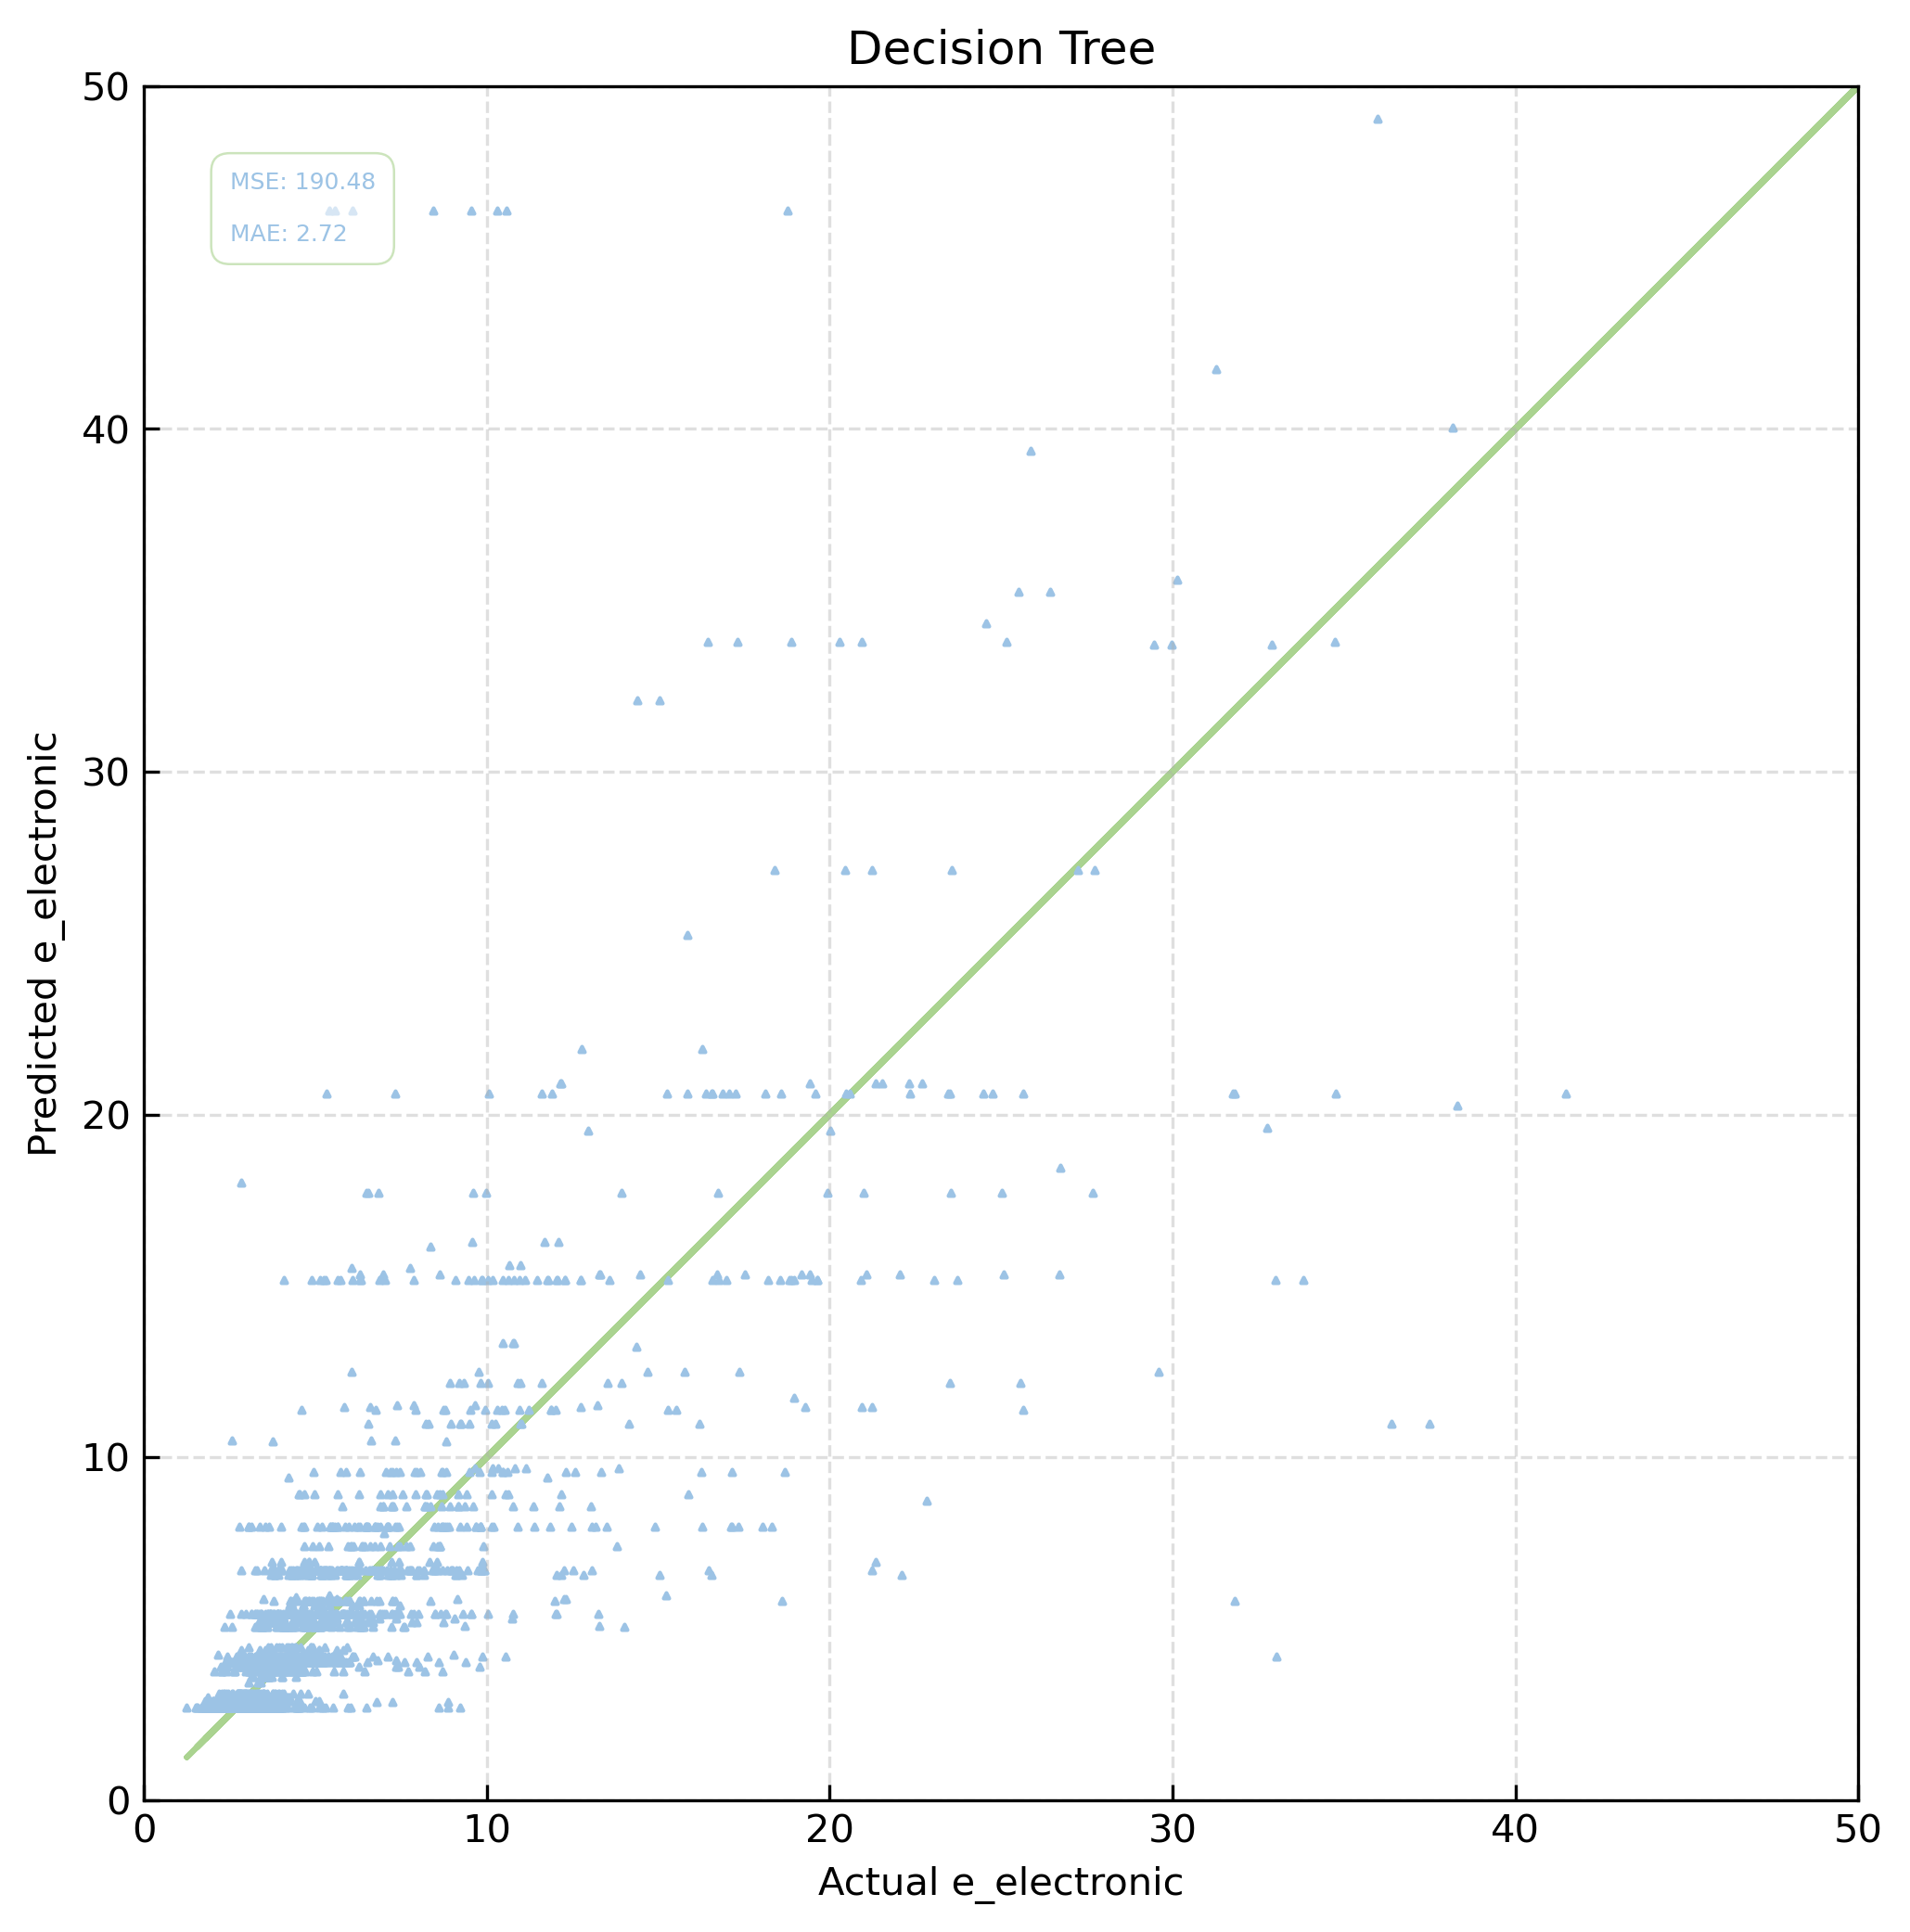

In [25]:
mse, mae, y_pred = model_test(dt, X_test_scaled, y_test)
plot_scores(mse, mae, y_test, y_pred, title='Decision Tree', fig_path=FIG_PATH)

## Random Forest Model

In [26]:
from sklearn.ensemble import RandomForestRegressor

### Model Train

In [27]:
rf = RandomForestRegressor(n_estimators=100, max_depth=BEST_DEPTH, random_state=RANDOM_STATE)
rf = model_final_train(rf, X_train_scaled, y_train)

### Model Test

MSE: 117.64522066892839, MAE: 2.3971359471920315


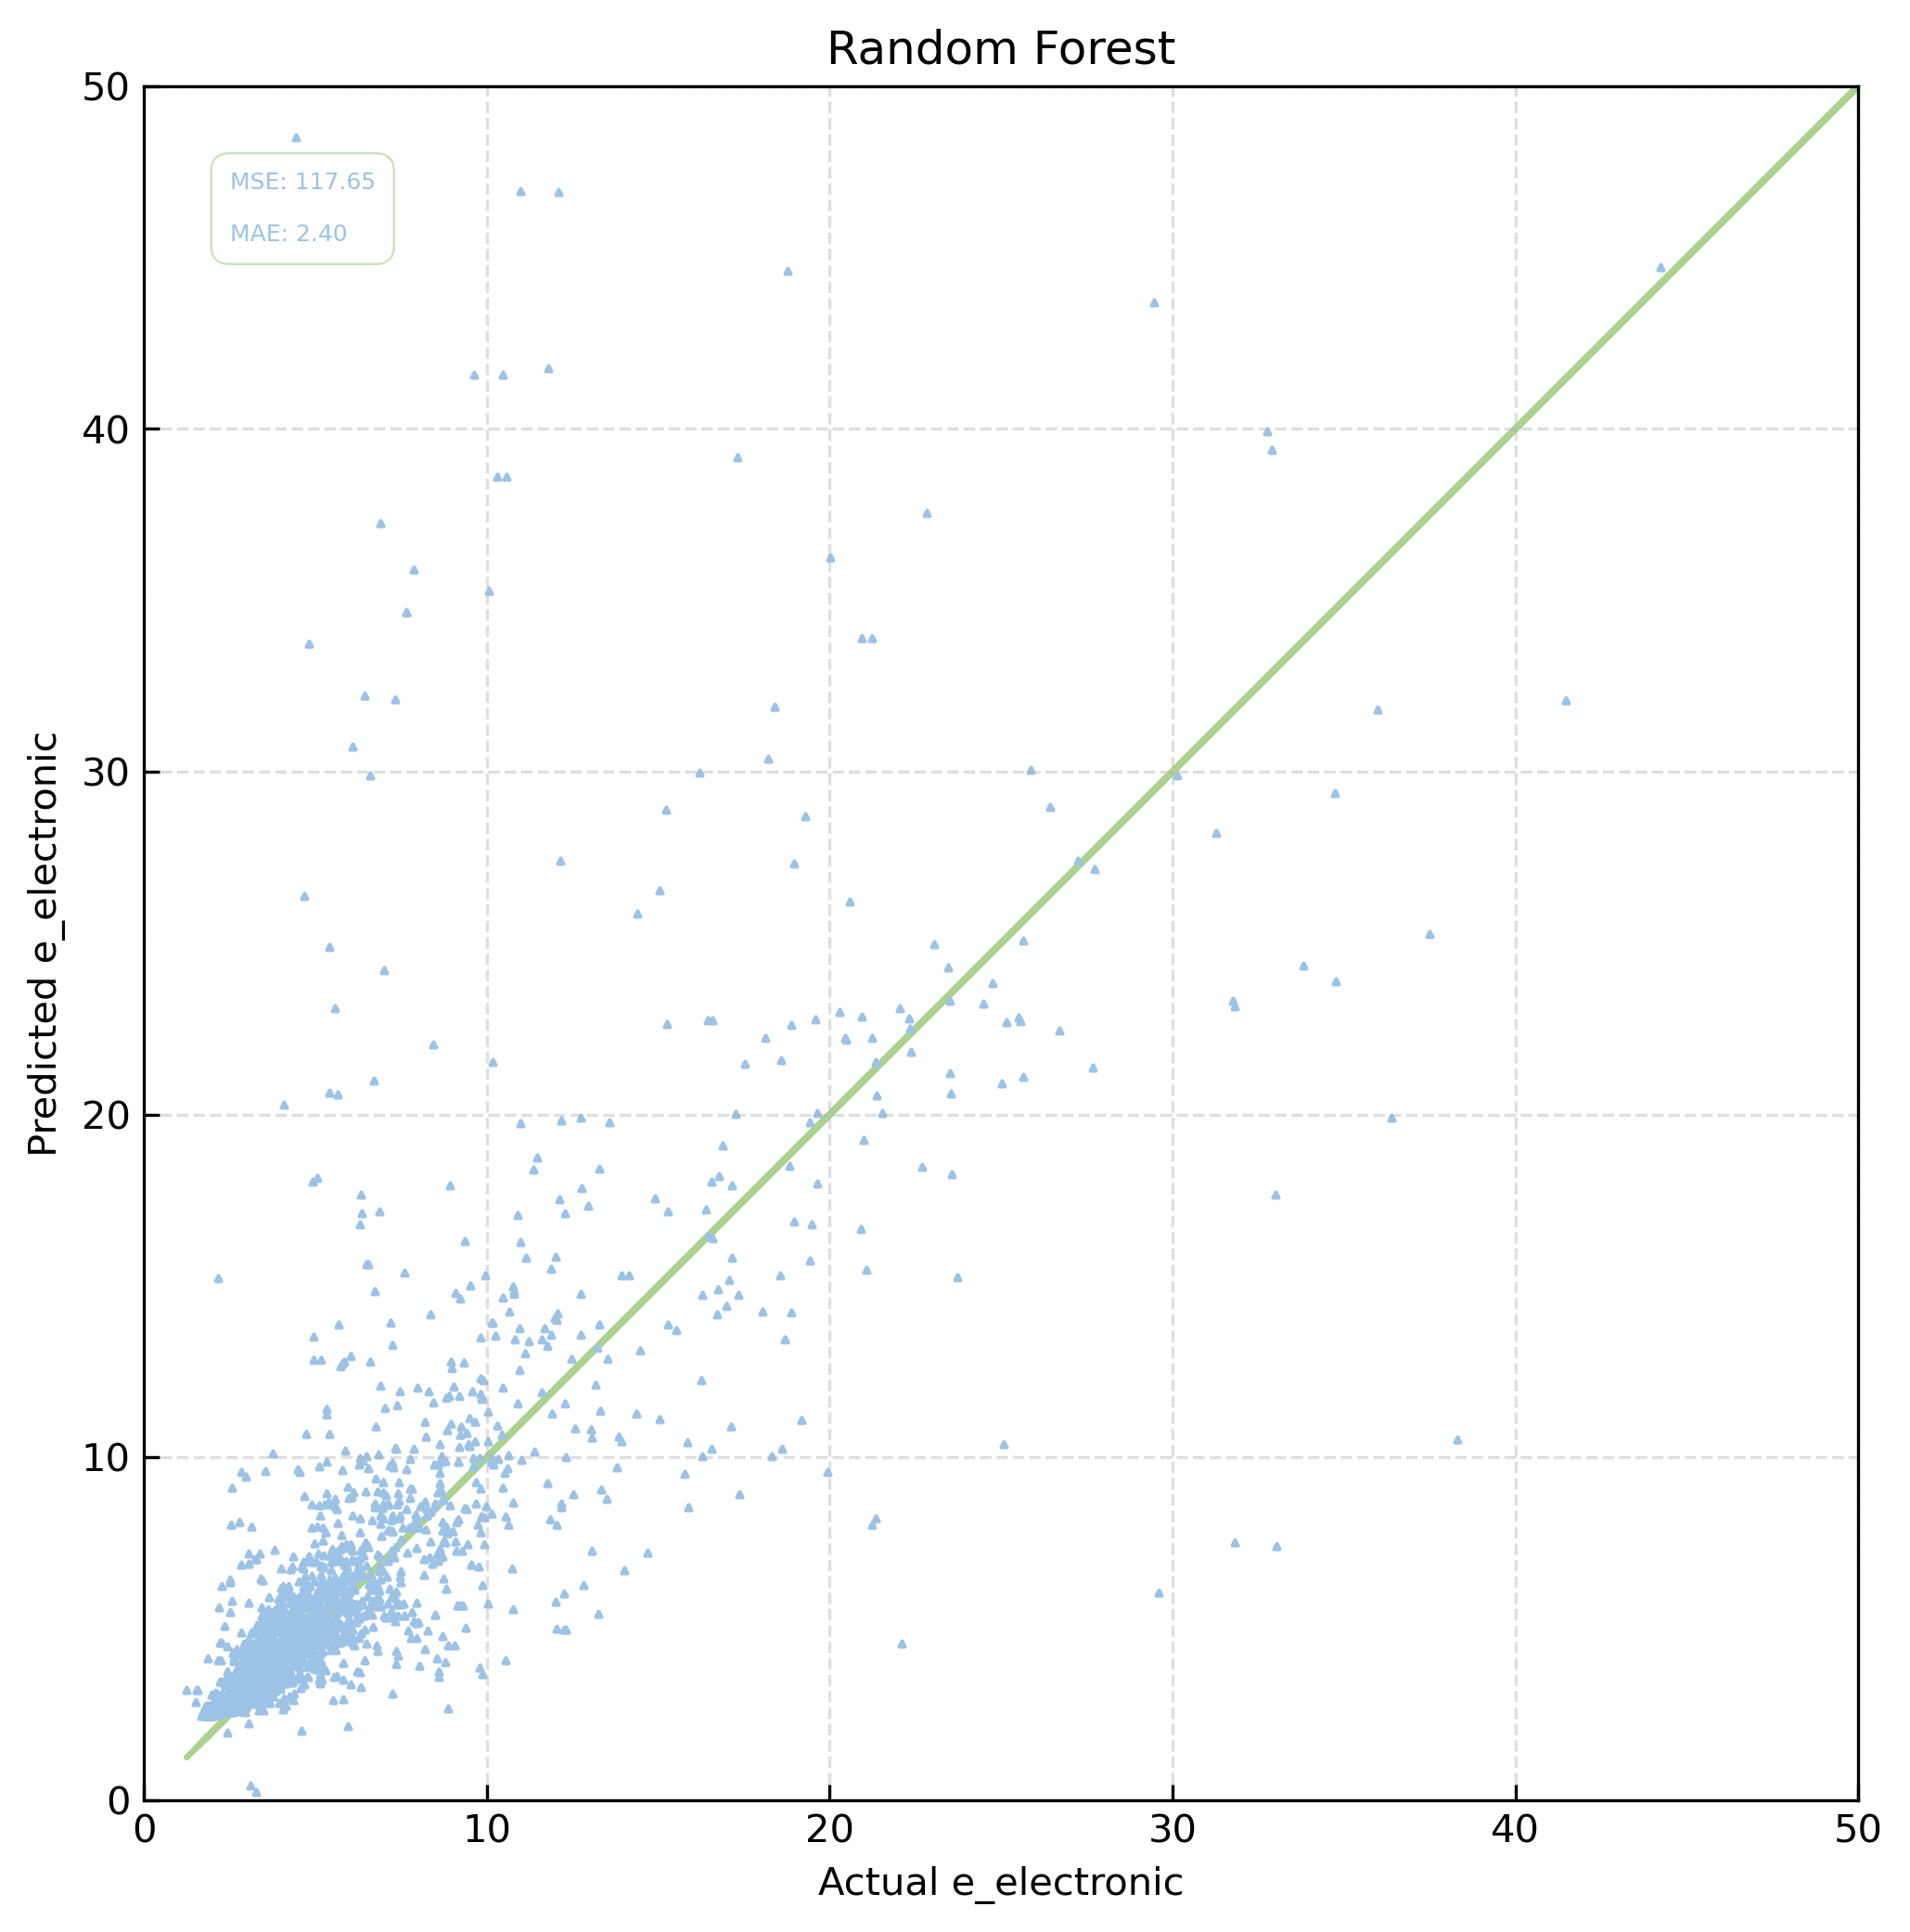

In [28]:
mse, mae, y_pred = model_test(rf, X_test_scaled, y_test)
plot_scores(mse, mae, y_test, y_pred, title='Random Forest', fig_path=FIG_PATH)